In [1]:
import os
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score

# Download NLTK resources (only needs to be done once)
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Step 1: Basic preprocessing

In [2]:
def simple_preprocess(text):
    if not isinstance(text, str):
        text = ""
    return word_tokenize(text.lower())

## Step 2: Compute average word embedding for a document

In [3]:
def average_embedding(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

## Step 3: Compute cosine similarity between two vectors

In [4]:
def compute_similarity(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]

## Step 4: Convert similarity score to class label (0 to 3)

In [5]:
def classify_similarity(sim):
    if sim >= 0.90:
        return 4
    elif sim >= 0.75:
        return 3
    elif sim >= 0.50:
        return 2
    else:
        return 1

## Main comparison function

In [6]:
def compare_articles(text_a, text_b, model):
    tokens_a = simple_preprocess(text_a)
    tokens_b = simple_preprocess(text_b)

    vec_a = average_embedding(tokens_a, model)
    vec_b = average_embedding(tokens_b, model)

    sim = compute_similarity(vec_a, vec_b)
    label = classify_similarity(sim)

    return sim, label

## Classification Prediction

In [7]:
def predict_classification_with_titles(X, model):
    predictions = []

    for _, row in X.iterrows():
        title_a = row['title1']
        title_b = row['title2']

        sim, label = compare_articles(title_a, title_b, model)
        predictions.append(label)

    return predictions

def predict_classification_with_text(X, model):
    predictions = []

    for _, row in X.iterrows():
        text_a = row['text1']
        text_b = row['text2']

        sim, label = compare_articles(text_a, text_b, model)
        predictions.append(label)

    return predictions

def predict_classification(X, model):
    predictions = []

    for _, row in X.iterrows():
        text_a = str(row['title1']) + " " + str(row['text1'])
        text_b = str(row['title2']) + " " + str(row['text2'])

        sim, label = compare_articles(text_a, text_b, model)
        predictions.append(label)

    return predictions

## Regression Prediction

In [8]:
def predict_regression_with_titles(X, model):
    predictions = []

    for _, row in X.iterrows():
        title_a = row['title1']
        title_b = row['title2']

        sim, label = compare_articles(title_a, title_b, model)
        # Rescale from [0, 1] → [1, 4]
        sim_rescaled = 1 + sim * 3
        predictions.append(sim_rescaled)

    return predictions

def predict_regression(X, model):
    predictions = []

    for _, row in X.iterrows():
        text_a = str(row['title1']) + " " + str(row['text1'])
        text_b = str(row['title2']) + " " + str(row['text2'])

        sim, label = compare_articles(text_a, text_b, model)
        # Rescale from [0, 1] → [1, 4]
        sim_rescaled = 1 + sim * 3
        predictions.append(sim_rescaled)

    return predictions

## Main Evaluation Function

In [9]:
def evaluate(data, model):
    # Predict as Classification
    print("\nClassification using only titles...")
    data['pred_class_title_only'] = predict_classification_with_titles(data, model)
    acc = accuracy_score(data['overall_classification'], data['pred_class_title_only'])
    print(f"Accuracy Classification (titles only): {acc:.3f}")

    print("\nClassification using only text...")
    data['pred_class_text_only'] = predict_classification_with_text(data, model)
    acc = accuracy_score(data['overall_classification'], data['pred_class_text_only'])
    print(f"Accuracy Classification (text only): {acc:.3f}")

    # Predict as Regression
    print("\nRegression using only titles...")
    data['pred_reg_title_only'] = predict_regression_with_titles(data, model)
    # Scale from [0, 1] to [1, 4] range
    data['pred_reg_title_only'] = data['pred_reg_title_only'] * 3 + 1

    mse = mean_squared_error(data['overall'], data['pred_reg_title_only'])
    mae = mean_absolute_error(data['overall'], data['pred_reg_title_only'])
    r2 = r2_score(data['overall'], data['pred_reg_title_only'])

    print("Scores Regression (titles only):")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² : {r2:.4f}")

    print()
    display(data)

## Evaluation with Word2Vec

In [10]:
# Load CSV with all pairs
print("Loading CSV...")
df = pd.read_csv("data/full_dataset.csv")

# Load pre-trained Word2Vec model (Google News vectors)
print("Loading Word2Vec model ...")
model = KeyedVectors.load_word2vec_format("pretrained_models/word2vec/GoogleNews-vectors-negative300.bin", binary=True)

evaluate(df, model)

Loading CSV...
Loading Word2Vec model ...

Classification using only titles...
Accuracy Classification (titles only): 0.156

Classification using only text...


KeyboardInterrupt: 

## Evaluation with FastText

In [11]:
# Load CSV with all pairs
print("Loading CSV...")
df2 = pd.read_csv("data/full_dataset.csv")

# Load FastText word vectors
print("Loading FastText model...")
if os.path.exists("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv"):
    model2 = KeyedVectors.load("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv")  # faster loading
else:
    model2 = KeyedVectors.load_word2vec_format("pretrained_models/fasttext/wiki-news-300d-1M-subword.vec")
    model2.save("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv")

evaluate(df2, model2)

Loading CSV...
Loading FastText model...


FileNotFoundError: [Errno 2] No such file or directory: 'pretrained_models/fasttext/wiki-news-300d-1M-subword.vec'

# Evaluate with Test Data

In [12]:
test_df = pd.read_csv("test_data/test_dataset.csv")

test_y_true = test_df["overall"]
test_y_true_classification = test_df["overall_classification"]

test_X = test_df.drop(columns=[
    "overall",
    "overall_classification",
    "geography", "entities", "time", "narrative", "style", "tone"
])


Classification Evaluation for Word Embeddings - Cosine Similarity (Classifier)
Accuracy: 0.237
Precision (weighted): 0.227
Recall (weighted): 0.237
F1 Score (weighted): 0.208

Classification Report:
              precision    recall  f1-score   support

           1      0.205     0.244     0.223       970
           2      0.223     0.049     0.080       885
           3      0.203     0.110     0.143       700
           4      0.265     0.459     0.336      1121

    accuracy                          0.237      3676
   macro avg      0.224     0.216     0.195      3676
weighted avg      0.227     0.237     0.208      3676



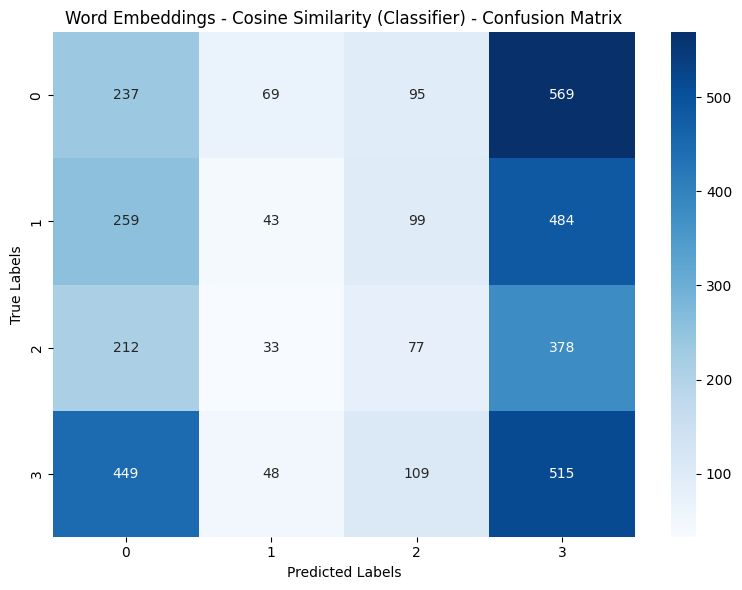

Results saved to: eval_results\word_cosine_classification.json


In [14]:
import common_evaluation

test_y_pred = predict_classification(test_X, model)
results = common_evaluation.evaluate_classification(test_y_true_classification, test_y_pred, description="Word Embeddings - Cosine Similarity (Classifier)", save_json_file_name="word_cosine_classification.json")



Regression Evaluation for Word Embeddings - Cosine Similarity (Regression)
Mean Squared Error (MSE): 3.278
Mean Absolute Error (MAE): 1.481
R2 Score: -1.389


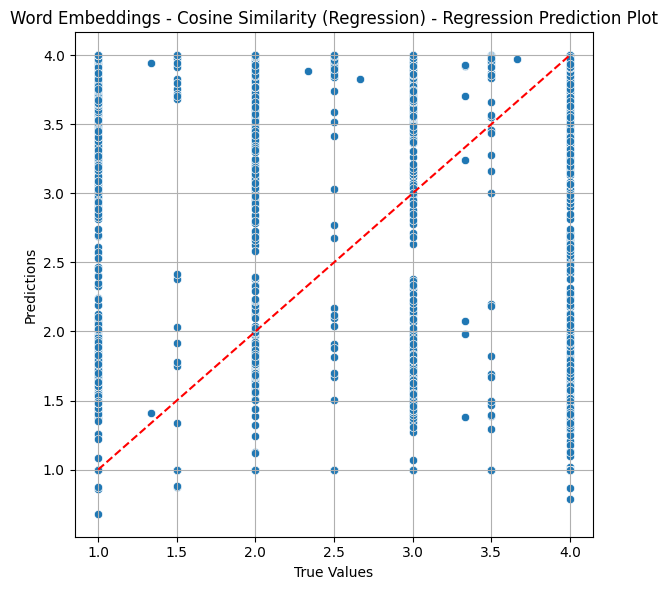

Results saved to: eval_results\word_cosine_regression.json


In [15]:
test_y_pred = predict_regression(test_X, model)
results = common_evaluation.evaluate_regression(test_y_true, test_y_pred, description="Word Embeddings - Cosine Similarity (Regression)", save_json_file_name="word_cosine_regression.json")

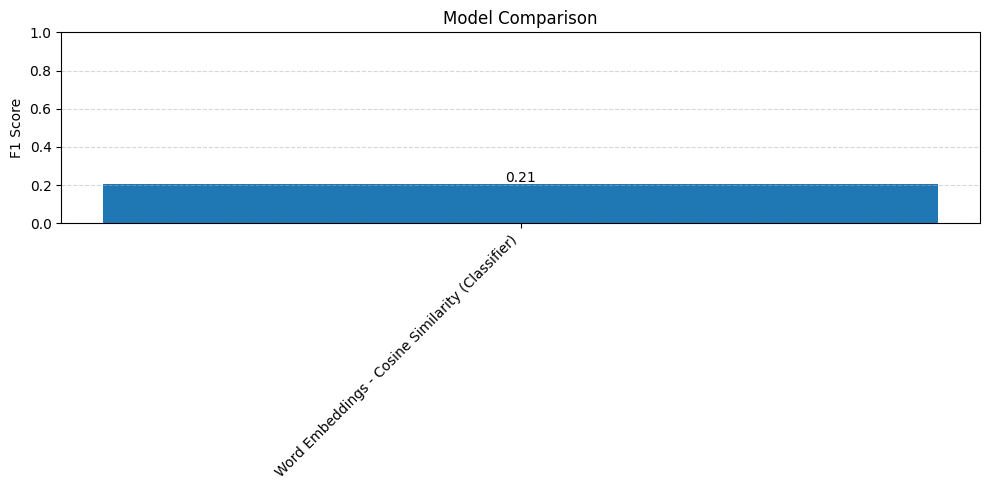

In [18]:
results = common_evaluation.load_all_results()
common_evaluation.plot_model_comparison(results, metric="F1 Score")